In [1]:
# Libraries

# Python

from random import shuffle
import pandas as pd
import numpy as np
import sys
import json

# Machine Learning

import tensorflow as tf
from tensorflow import keras
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Data / Plotting

import matplotlib.pyplot as plt
import pymatgen as pymat
import mendeleev as mendel

%matplotlib inline

Using TensorFlow backend.


In [16]:
# Get all the elements 
elements_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg',
            'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr',
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br',
            'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag',
            'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'Hf', 'Ta', 'W',
            'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'La', 'Ce', 'Pr',
            'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
            'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu']

# Create element dictionary
element_property = {}

for item in elements_list:
    element_property[item] = {}
    #element_property[item]["youngs_modulus"]= pymat.Element(item).youngs_modulus
    element_property[item]["lattice_constant"] = mendel.element(item).lattice_constant
    element_property[item]["melting_point"] = mendel.element(item).melting_point
    element_property[item]["specific_heat"]= mendel.element(item).specific_heat
    element_property[item]["atomic_mass"] = pymat.Element(item).atomic_mass
    element_property[item]["CTE"] = pymat.Element(item).coefficient_of_linear_thermal_expansion
    element_property[item]["electrical_resistivity"] = pymat.Element(item).electrical_resistivity
    element_property[item]["atomic_radius"] = pymat.Element(item).atomic_radius
    element_property[item]["density_of_solid"] = pymat.Element(item).density_of_solid
    #element_property[item]["poissons_ratio"] = pymat.Element(item).poissons_ratio

In [17]:
# Load in our hardness and yield data
raw_data = np.loadtxt(open("clean_data_with_elements.csv", "r"), delimiter = ',', dtype = str, skiprows = 0)

# Get the labels
labels = raw_data[0]

df = pd.DataFrame(raw_data[1:], columns = labels)

# Drop the 'other' column because... it's pretty useless information for us
df = df.drop('Other', axis = 1)

# Also, drop these elments because they do not appear in the materials at all...
df = df.drop(['As', 'Sn', 'Ta'], axis = 1)

# We want to convert some of these columns to floating points
df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)

## Pandas Profile
This report will tell us some general statistics about our data.

In [ ]:
pd.read_csv("clean_data_with_elements.csv").profile_report()

In [18]:
# The data looks like this now
df.head()

,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,P,Pb,S,Se,Si,Ti,V,W,Zn,Zr
0,MINFM3654700,95,168,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
1,MINFM3654300,30,55,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
2,MINFM3654600,95,168,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
3,MINFM3654500,65,127.5,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
4,MINFM3654400,65,122.5,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0


In [19]:
# We are going to remove all the elements that are not present in any material from the dictionary

# First, make a list of the elements present
elems_present = df.iloc[:,3:-1].columns

# Create a function for "soft" removing a key
def removekey(d, key):
    dcopy = dict(d)
    del dcopy[key]
    return dcopy

# Loop through the elements (keys) in the dictionary
for key in element_property:
    # If said element is not in the list of elems_present...
    if key not in elems_present: 
        # Then, remove that key
        element_property = removekey(element_property,key)
        
print(len(element_property.keys()))
print(len(elems_present))

25
25


In [7]:
# Now, we are going to fill the dictionary NA values with 0 values
# This should not greatly impact the properties of the materials because the properties are not averaged.
# They are taken as element_composition * element_property 
# Thus, if an NA is present, then it will treat that element as if it had 0 % composition
# This should not be significant since that element was not contributing to that property anyway

# Replace NA's with 0
element_property = {k: {k2: 0 if v2 == None else v2 for k2, v2 in v.items()} \
                    for k, v in element_property.items()}

In [20]:
# Now, we are going to get the "weighted" properties of the elements present

# Get only the elemental compositions and make sure they are numerical values
elem_df = df.iloc[:,3:-1].copy().apply(pd.to_numeric)

# Create a dataframe to which we will add the properties
final_data = df.copy()

elem_df.head()

,Al,B,Bi,C,Ca,Ce,Co,Cr,Cu,Fe,...,Ni,P,Pb,S,Se,Si,Ti,V,W,Zn
0,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25
1,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25
2,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25
3,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25
4,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25


In [21]:
# Here, we create the function that will add the "weighted" properties to the final dataframe
# As in, the percent composition of element A will be multiplied by whatever property of element A (divided by 100)
# Then, all the values for each element will be added to come up with a "weighted" property average unique to the material

def weighted_properties(x): # Enter a property
    # Create a copy of the elemental dataframe
    mod_temp = elem_df.copy()
    
    # For each item in the elements... 
    for item in mod_temp.columns.tolist():
        # Add to the temporary df the elemental composition mod_temp[item] multiplied by whatever property we are referencing
        # Then, divide by 100 since composition is in percent
        mod_temp[item] *= element_property[item][x]/100
    # Add the individual values to get the "weighted" average, and add this to the dataframe
    final_data[x] = mod_temp.sum(axis = 1, skipna = True)

In [25]:
# Now, we'll apply our function to all our properties (this could take a while)
#weighted_properties('youngs_modulus')
weighted_properties('lattice_constant')
weighted_properties('melting_point')
#weighted_properties('specific_heat')
weighted_properties('atomic_mass')
#weighted_properties('CTE')
#weighted_properties('electrical_resistivity')
weighted_properties('atomic_radius')
#weighted_properties('density_of_solid')
#weighted_properties('poissons_ratio')

In [26]:
# Here, we take the difference in the maximum atomic radius present and the minimum atomic radius present for each material
binary_temp = elem_df.copy()
binary_temp.where(binary_temp == 0, 1, inplace = True)

mod_binary_temp = binary_temp.copy()
for item in mod_binary_temp.columns.tolist():
    mod_binary_temp[item] *= element_property[item]["atomic_radius"]
final_data["max_min_radius"] =  mod_binary_temp.max(axis = 1) - mod_binary_temp[mod_binary_temp > .01].min(axis=1)

In [27]:
# Rename
df = final_data
df.head()

,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,Ti,V,W,Zn,Zr,lattice_constant,melting_point,atomic_mass,atomic_radius,max_min_radius
0,MINFM3654700,95,168,95.8,0,0,0,0,0,0,...,0.15,0,0,0.25,0,3.978367,930.850725,26.979858,1.23386,0.4
1,MINFM3654300,30,55,95.8,0,0,0,0,0,0,...,0.15,0,0,0.25,0,3.978367,930.850725,26.979858,1.23386,0.4
2,MINFM3654600,95,168,95.8,0,0,0,0,0,0,...,0.15,0,0,0.25,0,3.978367,930.850725,26.979858,1.23386,0.4
3,MINFM3654500,65,127.5,95.8,0,0,0,0,0,0,...,0.15,0,0,0.25,0,3.978367,930.850725,26.979858,1.23386,0.4
4,MINFM3654400,65,122.5,95.8,0,0,0,0,0,0,...,0.15,0,0,0.25,0,3.978367,930.850725,26.979858,1.23386,0.4


In [28]:
# Now, we want to get rid of "duplicate" materials
# It could prove difficult if there are many with exactly the same composition but different hardness and yield values. 
# It means that they are the same material, but they were processed differently. Thus, we are going to remove all the duplicates,
# leaving only one material with that composition. This materials will be the one with the lowest hardness value

duplicate_df = df[df.iloc[:, 3:].duplicated()]

# That's... a lot of duplicates
print(len(duplicate_df))

# We're going to attempt to keep ONE of the values from all the duplicates (see next cell)

1507


In [29]:
# DUPLICATING CRITERIA, WE KEEP THE ONE IN THE MEDIAN

duplicated_indexes = df[df.duplicated(subset = df.columns.tolist()[3:], keep=False)].index.tolist()

another_df = df[df.duplicated(subset = df.columns.tolist()[3:], keep=False)]

list_duplicates = [np.array(another_df.iloc[x]) for x in range(len(another_df.index))]

grouped_duplicates = []

for outer_index in range(len(list_duplicates)):
    for inner_index in range(outer_index+1,len(list_duplicates)):
        if np.array_equal(list_duplicates[outer_index][3:], list_duplicates[inner_index][3:]):
            grouped_duplicates.append([duplicated_indexes[outer_index], duplicated_indexes[inner_index]])

# -------------------------------------------------------
# CODE TO MERGE LISTS OF LISTS WITH REPEATED ELEMENTS TO INDIVIDUAL LISTS OF LISTS. Taken from: https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
resultlist = [grouped_duplicates[0]]

for l in grouped_duplicates[1:]: #Loop through lists starting at list 1
    listset = set(l) #Turn you list into a set
    merged = False
    for index in range(len(resultlist)): #Use indexes of the list for speed.
        rset = set(resultlist[index]) #Get list from you resultset as a set
        if len(listset & rset) != 0: #If listset and rset have a common value then the len will be greater than 1
            resultlist[index] = list(listset | rset) #Update the resultlist with the updated union of listset and rset
            merged = True #Turn trigger to True
            break #Because you found a match there is no need to continue the for loop.
    if not merged: #If there was no match then add the list to the resultset, so it doesnt get left out.
        resultlist.append(l)

# -------------------------------------------------------
# Grouped_set is a list of lists. Each list contains every index of an 'identical' material. For example, if the first five
# materials have exactly the same composition, then the first entry in resultlist will be [0,1,2,3,4].

# IMPORTANT! I am going to assume that, out of all the duplicates, the 'pure' material is the one with the lowest hardness value.
# This is a reasonable assumption since most processing techniques exist to harden/toughen a material or to soften one that's
# already been processed!
for grouped_set in resultlist: # For each list of index values    
    # Create an empty dataframe
    hard_df = pd.DataFrame(columns = ['internal_id','min_hardness', 'yield'])
    for i in range(0,len(grouped_set)): # Fill said dataframe with the hardness and yield values 
                                        # of all identical materials of a certain composition
        hard_df.loc[i] = [df.at[grouped_set[i], "internal_id"], df.at[grouped_set[i],"avg_hardness"], df.at[grouped_set[i],"avg_yield"]]
    
    # Now, we will sort the dataframe by minimum value first, create a list of those values, and take only the first entry
    min_hardness = (hard_df.sort_values(by = 'min_hardness').values)[0]
    
    # Set the internal id in our original dataframe to the one that is associated with the minimum hardness values
    df.at[grouped_set[0], "internal_id"] = min_hardness[0]
    # Set the avg_hardness in our original dataframe for that index to the minimum hardness value (all else stays the same)
    df.at[grouped_set[0],"avg_hardness"] = min_hardness[1]
    # Set the avg_yield in our original dataframe to the associated yield value (for that index)
    df.at[grouped_set[0],"avg_yield"] = min_hardness[2]
    
    # Drop everything else
    df = df.drop(grouped_set[1:], axis = 0)
# This is the length of our dataframe now
print(len(df))
# This is what our dataframe looks like now
df.head()

884


,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,Ti,V,W,Zn,Zr,lattice_constant,melting_point,atomic_mass,atomic_radius,max_min_radius
0,MINFM3654300,30,55,95.8,0,0,0,0,0,0,...,0.15,0,0,0.25,0,3.978367,930.850725,26.979858,1.23386,0.40
5,COME029,80,280,0,0,0,0,0,0,0,...,0,0,0,0,0,3.208000,1765.360000,57.326168,1.37400,0.05
6,COME051,333.5,827,0.5,0,0,0,0,0,0,...,0.9,0,0,0,0,3.235700,1890.734500,59.128091,1.36835,0.20
7,MITF730,95,250,91.3,0,0.2,0,0,0,0,...,0,0,0,0.3,0,3.947340,943.871990,29.343290,1.23380,0.70
16,MITF3230,58,95,94.4,0,0,0,0,0,0,...,0.2,0,0,0.2,0,3.975805,932.565560,26.940651,1.24520,0.40


In [30]:
# Now, we should clean up this data

# Make all the data numeric first
df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)

# We're also going to check for any columns that are all zero. If this is the case, then the standard deviation
# will be zero, so we would be dividing by zero!
df.loc[:, (df == 0).all(axis=0)].head()

""
0
5
6
7
16


In [40]:
# We're going to check for any NA's since those could give us problems later
print(df.isnull().values.any())

# Find and drop those NaN
to_drop = list(df[df.isna().any(axis=1)].index)
df = df.drop(to_drop, axis = 0)

False


In [32]:
# Now, I will drop any materials with total elemental compositions < 90%

# Make numeric
df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)

# Make a subset of dataframes with only elemental composition
elem_comps = df.iloc[:, 3:-11].copy()

# Add a column that has the sum of the elemental compositions
df['sum'] = elem_comps.sum(axis = 1) 

# Drop materials with a total elemental composition < 90%
df = df[df['sum'] >= 90]

# Now drop the 'sum' column
df = df.drop('sum', axis = 1)

print(len(df))
df.head()

668


,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,Ti,V,W,Zn,Zr,lattice_constant,melting_point,atomic_mass,atomic_radius,max_min_radius
0,MINFM3654300,30.0,55.0,95.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.15,0.0,0.0,0.25,0.0,3.978367,930.850725,26.979858,1.23386,0.40
5,COME029,80.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,3.208000,1765.360000,57.326168,1.37400,0.05
6,COME051,333.5,827.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.90,0.0,0.0,0.00,0.0,3.235700,1890.734500,59.128091,1.36835,0.20
7,MITF730,95.0,250.0,91.3,0.0,0.2,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.30,0.0,3.947340,943.871990,29.343290,1.23380,0.70
16,MITF3230,58.0,95.0,94.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20,0.0,0.0,0.20,0.0,3.975805,932.565560,26.940651,1.24520,0.40


In [33]:
# Now, we also need to check for elements that appear 'infrequently.' If there are few enough materials containing a certain element
# that all of the materials with that element are sorted (randomly) into the testing set, that means that our neural net won't know
# how to predict the hardness (having never encountered that element in the training set)! 
# Here, we (somewhat arbitrarily) choose 20 as our minimum value

# We also (of course), get rid of any elements that don't appear at all!

# This will create a list of how many times each column is a nonzero number
num_zeros = list(df.astype(bool).sum(axis=0))
print(num_zeros)  # The first three will be as long as the dataframe
print(df.columns) # Print the columns so that we can see which columns have low non-zero entries

# We make an empty list to "which we will add all of the 'infrequent' elements
low_entries = []

for i,j in enumerate(num_zeros):
    if j < 20:
        low_entries.append(True)
    else:
        low_entries.append(False)

# Create a list of the elements that need to be dropped       
to_drop = []
for i,j in enumerate(low_entries):
    if j == True:
        to_drop.append(df.columns.to_list()[i])
print(to_drop)

[668, 668, 668, 34, 22, 1, 364, 1, 5, 0, 475, 42, 665, 16, 409, 258, 48, 19, 257, 7, 2, 27, 2, 283, 27, 53, 11, 16, 3, 668, 668, 668, 668, 595]
Index(['internal_id', 'avg_hardness', 'avg_yield', 'Al', 'B', 'Bi', 'C', 'Ca',
       'Ce', 'Co', 'Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'P',
       'Pb', 'S', 'Se', 'Si', 'Ti', 'V', 'W', 'Zn', 'Zr', 'lattice_constant',
       'melting_point', 'atomic_mass', 'atomic_radius', 'max_min_radius'],
      dtype='object')
['Bi', 'Ca', 'Ce', 'Co', 'Mg', 'Nb', 'P', 'Pb', 'Se', 'W', 'Zn', 'Zr']


In [34]:
# First, I'm going to drop any rows (AKA, materials) that had any of the 'infrequent' elements

for element in to_drop:
    # Get the index of any materials where the value is not equal to zero for the elements in to_drop
    indexNames = df[df[element] != 0].index
    
    # Delete these row indexes from dataframe
    df.drop(indexNames, inplace=True)

# Now, I'm going to drop any columns (elements) that were 'infrequent' and convert everything to numerical values
df = df.drop(to_drop, axis = 1)

# We should also drop any rows of all zeros (if those are there, for whatever reason)
df = df[(df.iloc[:,3:].T != 0).any()]

# This is the number of nonzero values in each column (once again)
num_nonzero = list(df.astype(bool).sum(axis=0))
print(num_nonzero)

# How long our dataframe is now
print("The length of the DataFrame now is")
print(len(df))

[607, 607, 607, 13, 21, 348, 430, 20, 607, 374, 238, 42, 237, 21, 255, 17, 44, 607, 607, 607, 607, 534]
The length of the DataFrame now is
607


In [35]:
# Finally, I'm also going to drop the avg_yield column, since this IS what we want to predict
# I will also make a list of it to use later
all_labels = df['avg_yield'].tolist()
df = df.drop(['avg_yield'], axis=1)

# See what it looks like now
df.head(10)

,internal_id,avg_hardness,Al,B,C,Cr,Cu,Fe,Mn,Mo,...,Ni,S,Si,Ti,V,lattice_constant,melting_point,atomic_mass,atomic_radius,max_min_radius
5,COME029,80.0,0.0,0.0,0.00,0.00,0.0,48.0000,0.0,0.00,...,52.00,0.0,0.00,0.0,0.0,3.208000,1765.360000,57.326168,1.374000,0.05
70,MINFM7375,114.0,0.0,0.0,0.00,17.00,0.0,67.0499,0.0,0.00,...,8.00,0.0,0.00,0.0,0.0,2.695532,1712.442192,50.978826,1.284699,0.05
72,MINFM7378,114.0,0.0,0.0,0.00,17.00,0.0,67.5899,0.0,0.00,...,8.00,0.0,0.00,0.0,0.0,2.711030,1722.205392,51.280389,1.292259,0.05
73,MINFM50412,85.0,0.0,0.0,0.00,22.00,0.0,57.8449,0.0,0.00,...,12.00,0.0,0.00,0.0,0.0,2.716149,1721.555792,50.785834,1.279829,0.05
77,MINFM7562,254.0,0.0,0.0,0.20,0.00,0.0,98.1749,0.7,0.20,...,0.00,0.0,0.15,0.0,0.0,2.901435,1801.565692,55.468369,1.390199,0.75
80,MINFM7928,107.5,0.0,0.0,0.60,16.00,0.0,78.4299,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,2.733158,1781.732592,52.190618,1.326219,0.70
82,MINFM8063,299.0,0.0,0.0,0.18,0.00,0.0,95.0699,0.5,0.20,...,3.25,0.0,0.15,0.0,0.0,2.908227,1797.724292,55.529639,1.387664,0.75
83,MINFM7808,110.0,0.0,0.0,0.00,12.00,0.0,82.8399,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,2.723105,1753.345392,52.501474,1.327759,0.00
84,MINFM50423,110.0,0.0,0.0,0.00,12.00,0.0,83.3299,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,2.737168,1762.204592,52.775115,1.334619,0.00
85,MINFM8453,176.0,0.0,0.0,0.19,0.35,0.0,96.7999,0.6,0.15,...,0.35,0.0,0.15,0.0,0.0,2.873550,1786.857692,54.983804,1.378379,0.75


Shape of Values: (607, 20)
Shape of Labels: (607,)
Sample entry from training set
[-1.16410294 -0.14307956 -0.10544514 -0.81705985 -0.81486226 -0.15461974
 -2.50322828 -0.42817511 -0.39098463 -0.21884172  8.88566529 -0.18628934
 -0.38822661 -0.10414369 -0.21318326  3.58719915 -0.15002134  2.02781035
  0.5689915  -1.41369574]
388.95799011532125
243.5168880366566


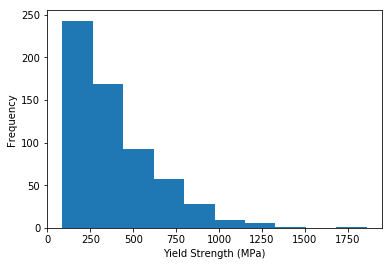

In [36]:
import random

# I get all the values as a numpy array here
all_values = df.iloc[:,1:].values
id_values = df.iloc[:,0].values

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float) 
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = float)
print("Shape of Labels:", all_labels.shape)

# Uncomment the line below to shuffle the dataset (we do not do this here to ensure consistent results for every run)
#order = list(range(0, len(df)))
#random.shuffle(order)         # This numpy argsort returns the indexes that would be used to shuffle a list
order = np.arange(len(df))
some_values = all_values[order]
some_labels = all_labels[order]
some_materials = (df.iloc[:,0].values)[order]
id_values = id_values[order]

# We'll use this for the splitting of our data in to training and testing
length = int(np.rint(0.10*len(df)))

# Training Set
train_labels = some_labels[:(len(df) - length)]
train_values = some_values[:(len(df) - length)]

# Testing Set
test_labels = some_labels[-length:]
test_values = some_values[-length:]

# NORMALIZATION

mean = np.mean(train_values, axis = 0) # mean
std = np.std(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

# This line is used for labels in the plots
# Marked in red
labeled_materials = id_values[(len(df)-length):]
# Marked in blue
materials = id_values

#print(order)
print("Sample entry from training set")
print(train_values[0]) # print a sample entry from the training set

# Here is the average and standard devation of the hardness for reference (uncomment if you wish to see them)
yield_avg = np.mean(all_labels)
yield_std = np.std(all_labels)
print(yield_avg) 
print(yield_std)

# Uncomment if you want to see a distribution of the hardness values
plt.hist(all_labels)
plt.xlabel('Yield Strength (MPa)')
plt.ylabel('Frequency')
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch.
Epoch 02434: early stopping


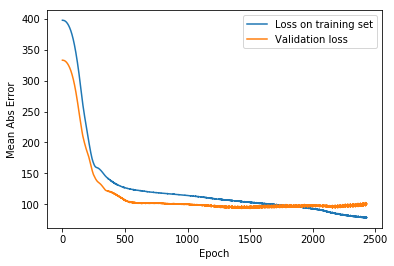

103.05324356023209 109.04001567402824


In [37]:
# Training!  

# DEFINITION OF THE MODEL
from keras.layers import LeakyReLU
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal()

model = Sequential()
model.add(Dense(36, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init))
model.add(Dense(22, activation='relu', kernel_initializer=kernel_init))
model.add(Dense(1, activation='relu', kernel_initializer=kernel_init))

# DEFINITION OF THE OPTIMIZER

optimizer = tf.train.RMSPropOptimizer(0.002) # Root Mean Squared Propagation

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
# model.summary() # Comment this out if you don't want to see the model summary

class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + '\r') # Updates current Epoch Number

mae_es= keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=1000, verbose=1, mode='auto', restore_best_weights=True)    
EPOCHS = 10000 # Number of EPOCHS

# HISTORY Object which contains how the model learned
# Training Values (Properties), Training Labels 
history = model.fit(train_values, train_labels, 
                        epochs = EPOCHS, verbose = False, shuffle = True, batch_size = len(df), validation_split = 0.10, callbacks=[mae_es, PrintEpNum()]) 


[loss_train, mae_train] = model.evaluate(train_values, train_labels, verbose=0)
[loss_test, mae_test] = model.evaluate(test_values, test_labels, verbose=0)


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),label = 'Validation loss')
plt.legend()
plt.show()

# Display the same information being written to the file
print(" ".join(str(x) for x in [mae_train, mae_test]))

In [38]:
# PLOTTING

test_predictions = model.predict(test_values).flatten()
'''
print("Materials in Test Set: ", labeled_materials)
print("Real Values", list(test_labels))
print("Predictions", list(test_predictions))
'''
values = np.concatenate((train_values, test_values), axis=0) # This line joins the values together to evaluate all of them
predictions = model.predict(values).flatten()

In [39]:
# PLOTTING
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

plotly.offline.init_notebook_mode(connected=True)

layout0= go.Layout(title= "Yield Strength", hovermode= 'closest',
    xaxis= dict(title= 'Real Values',zeroline= False, gridwidth= 2),
    yaxis= dict(title= 'Predictions',zeroline= False, gridwidth= 2),
    showlegend= False                 
)

trace0 = go.Scatter(x = all_labels, y = predictions, mode = 'markers', marker= dict(size= 12, color= 'blue'), text = id_values)
trace1 = go.Scatter(x = test_labels, y = test_predictions, mode = 'markers', marker= dict(size= 12, color= 'red'), text = labeled_materials)
trace2 = go.Scatter(x = [0,1500], y = [0,1500], mode = 'lines', name = "Match") # This trace is the line X = Y which would indicate that the Prediction equals the real value

data = [trace0, trace1, trace2]
fig= go.Figure(data, layout=layout0)
iplot(fig)